# Metrics explainer test

### 1. Collect test data to use for prediction

In [1]:
import os
import glob
import tensorflow as tf
import numpy as np
%matplotlib inline

# Collect samples for training/validation
train_dir = '../../../../train_logmel'

angry = glob.glob(os.path.join(train_dir,'angry/*.*'))
calm = glob.glob(os.path.join(train_dir,'calm/*.*'))
disgust = glob.glob(os.path.join(train_dir,'disgust/*.*'))
fearful = glob.glob(os.path.join(train_dir,'fear/*.*'))
happy = glob.glob(os.path.join(train_dir,'happy/*.*'))
neutral = glob.glob(os.path.join(train_dir,'neutral/*.*'))
sad = glob.glob(os.path.join(train_dir,'sad/*.*'))
surprised = glob.glob(os.path.join(train_dir,'surprise/*.*'))

data = []
labels = []
for i in angry:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Angry')
for i in calm:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Calm')
for i in disgust:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Disgust')
for i in fearful:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Fearful')
for i in happy:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Happy')
for i in neutral:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Neutral')
for i in sad:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Sad')
for i in surprised:
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Surprised')
    
# random split the 80/20 train/val examples
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(np.array(data), np.array(labels),
                                                  test_size=0.2, random_state=0)
train_labels = y_train
val_labels = y_val
# normalize
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_train /= 255
X_val /= 255

# one-hot encode classes
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_val = to_categorical(lb.fit_transform(y_val))
print(list(lb.classes_))

['Angry', 'Calm', 'Disgust', 'Fearful', 'Happy', 'Neutral', 'Sad', 'Surprised']


### 2. Load the trained VGG16 model 

In [2]:
clf = tf.keras.models.load_model('../../../../no_aug_VGG_TL.hdf5')

2022-10-14 13:01:30.861467: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-14 13:01:30.868389: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 


### 3. Make predictions

In [3]:
y = clf.predict(X_val)

### 4. Visualize results via a confusion matrix with *Explainer*

# Sandbox

In [32]:
class ConfusionMatrix:
    def __init__(self, groundtruth, predictions, labels):
        import sklearn
        from sklearn.metrics import confusion_matrix as cmx
        from sklearn.metrics import classification_report
        import pandas as pd
        pd.options.plotting.backend = "plotly"
        import numpy as np

        # ground truth
        self.y_gt = np.argmax(groundtruth, axis=1)
        # model predictions
        self.y_pred = np.argmax(predictions, axis=1)
        # label names
        self.labels = labels
        # array representation of the confusion matrix
        self.arr = cmx(self.y_gt, self.y_pred, normalize='true')
        # dataframe representation of the confusion matrix
        self.df = pd.DataFrame(self.arr, index = [i for i in self.labels],
                    columns = [i for i in self.labels]) 
        # str representation of metrics containing precision, recall, f1 and acc for each class
        self.report = classification_report(self.y_gt, self.y_pred, target_names=self.labels)


    def visualize(self):
        import matplotlib.pyplot as plt
        import seaborn as sn
        plt.figure(figsize=(10,7))
        sn.heatmap(self.df, annot=True)


class Plotter:
    def __init__(self,groundtruth,predictions,labels):
        from sklearn.metrics import precision_recall_curve
        from sklearn.metrics import roc_curve as sk_roc_curve
        import pandas as pd
        pd.options.plotting.backend = "plotly"
        

        self.y_gt = groundtruth
        self.y_pred = predictions
        self.labels = labels
        self.precision, self.recall = dict(), dict()
        self.tpr, self.fpr = dict(), dict()


        for i in range(len(self.labels)):
            self.precision[i], self.recall[i], _ = precision_recall_curve(self.y_gt[:, i], self.y_pred[:, i])
            self.fpr[i], self.tpr[i], _ = sk_roc_curve(self.y_gt[:, i], self.y_pred[:, i])

    def pr_curve(self):
        import plotly.express as px
        fig = px.line(title='PR Curve').update_layout(yaxis_title='Precision', xaxis_title='Recall')
        for i in range(len(self.labels)):
            fig.add_scatter(x=self.recall[i], y=self.precision[i], name=self.labels[i])

        fig.show()

    def roc_curve(self):
        import plotly.express as px
        fig = px.line(title="ROC Curve").update_layout(yaxis_title='TPR', xaxis_title='FPR')
        for i in range(len(self.labels)):
            fig.add_scatter(x=self.fpr[i], y=self.tpr[i], name=self.labels[i])

        fig.show()


cm = ConfusionMatrix(y_val,y,lb.classes_)
plotter = Plotter(y_val,y,lb.classes_)

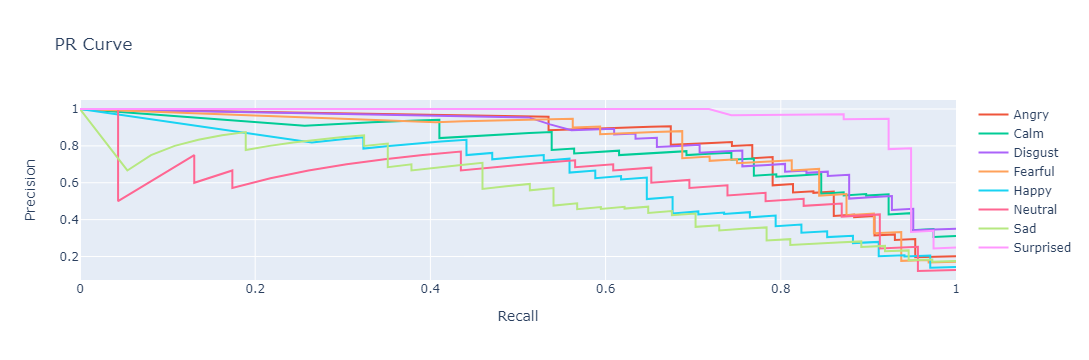

In [33]:
plotter.pr_curve()

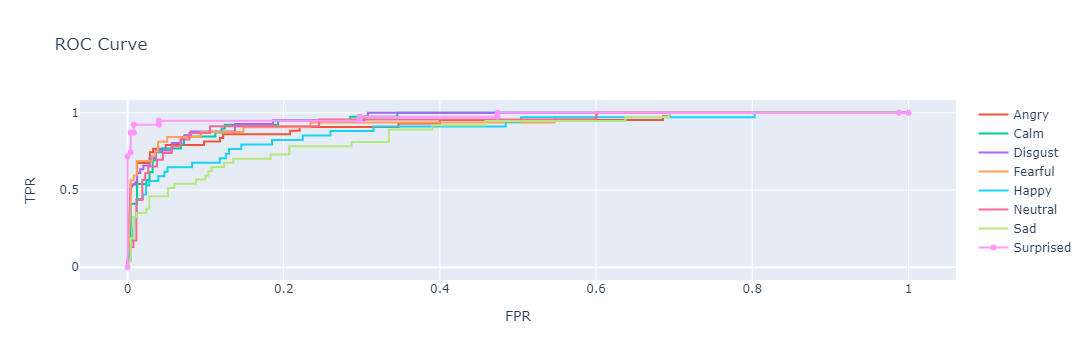

In [31]:
plotter.roc_curve()

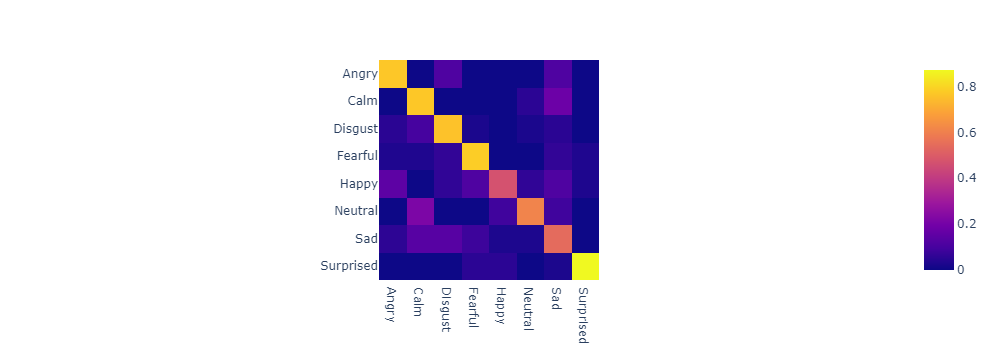

In [36]:
cm.df.plot(kind='imshow')

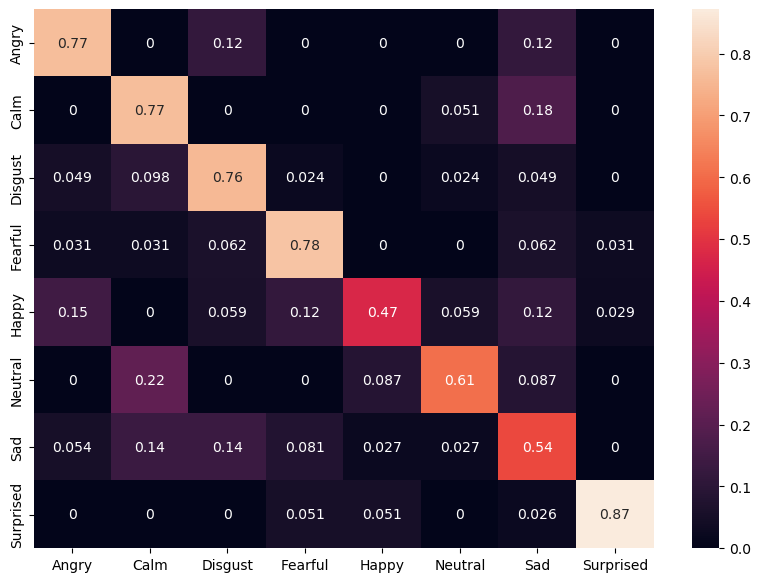

In [34]:
cm.visualize()